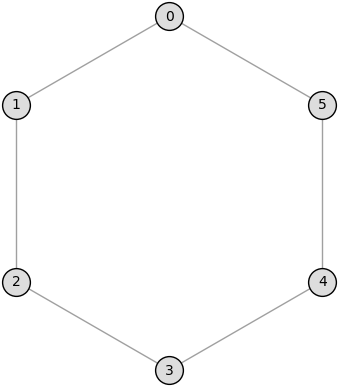

lmax = 10

 0:    6                                                             
 1:                                                                  
 2:         12                                                       
 3:                                                                  
 4:                     12                                           
 5:                                                                  
 6:                1     7          12                               
 7:                                                                  
 8:                            3    15          12                   
 9:                                                                  
10:                                        3    15          12       

In [28]:
# Graph Magnitude Homology Ranks Calculations
#
# Original maple code by Simon Willerton
# Translation into Python+SAGE by James Cranch
# Furhter modifications by Simon Willerton
#
# Execute the file with sage's inbuilt python via:
#   sage -python < rational_graph_homology_arxiv.py
#
# The program just generates the chain groups and calculates the differentials
# then uses the ChainComplex package to calculate the homology.
#
# For a graph g the chain groups MC_{*,*}(g) break up in to subcomplexes
# MC_{*,l}^{s,t}(g) where l is the length of the chain and s and t are the initial
# and terminal vertices of the chain.
# So here generators[s,t,k,l] is a list of the degree k generators of such a chain group.
# Then differential[s,t,k,l] is a matrix giving the differential from generators[s,t,k,l]
# to generators[s,t,k-1,l].
# The homology of each subcomplex is calculated then the ranks are added together to give
# the required output.


import sage.all

from sage.graphs.graph import Graph
from sage.graphs.distances_all_pairs import distances_all_pairs
from sage.homology.chain_complex import ChainComplex
#from sage.misc.ascii_art import ascii_art

from sage.graphs.graph_generators import GraphGenerators
graphs = GraphGenerators()

from sage.matrix.constructor import Matrix as matrix

from sage.rings.integer_ring import IntegerRing
from sage.rings.rational_field import RationalField
#from sage.rings.finite_rings.constructor import FiniteField
#BaseRing = IntegerRing()
BaseRing = RationalField()
#BaseRing = FiniteField(2)





def magnitude_homology(g,lmax=6):

    kmax = lmax +1

    d = distances_all_pairs(g)

    # populate the generators recursively
    generators = dict(((k,l),[]) for s in g.vertices() for t in g.vertices() for k in range(kmax+2) for l in range(lmax+1))
    def add_generators(a,l,x):
        k = len(a)-1
        s = a[0]
        if k<=kmax and l<=lmax:
            if k == 0 or a[k] != s:
                generators[(k,l)].append(a)
            for y in g.vertices():
                if x != y:
                    add_generators(a+[y],l+d[x][y]-d[x][s]+d[y][s],y)

    for x in g.vertices():
        add_generators([x],0,x)

    #print(generators)

    # number the generators, so as to produce differentials rapidly
    
    for l in range(lmax+1):
        for k in range(kmax+1):
            generators[(k,l)] = dict((tuple(a),i) for (i,a) in enumerate(generators[(k,l)]))
            #print(k, l, ":",generators[(k,l)])

    def differential(k,l):
        m = {}
        h = generators[(k-1,l)]
        #print('xd1:', k, l, generators[(k,l)])
        for (a,i) in generators[(k,l)].items():
            le = len(a)
            for z in range(len(a)):
                prev, cur, next = (z-1)%le, z%le, (z+1)%le

                if d[a[prev]][a[cur]] + d[a[cur]][a[next]] == d[a[prev]][a[next]]:
                    img = a[:cur]+a[cur+1:] if cur < len(a) - 1 else a[:cur]
                    #print(a, img)
                    j = h[img]
                    #print(a, img, "-", j)
                    if cur%2:
                        m[(j,i)] = m.get((j,i),0) + 1
                    else:
                        m[(j,i)] = m.get((j,i),0) - 1
        #print('xd2:', k, l, generators[(k,l)])
        #print(m, len(generators[(k,l)]))
        return matrix(BaseRing, len(h), len(generators[(k,l)]), m)


    def chains(l):
        differentials = dict((k,differential(k,l)) for k in range(1,kmax+1) if generators[(k,l)] or generators[(k-1,l)])
        #print(s, t, l, differentials, '\n\n')
        return ChainComplex(differentials, base_ring=BaseRing, degree=-1)




    def homology(l):
        ch = chains(l).homology(generators=False)
        #print(s,t,l, ch)
        return ch

    return dict((l,homology(l)) for l in range(lmax+1))

def figure_eight(m,n):
    g1 = graphs.CycleGraph(m)
    g2 = graphs.CycleGraph(n+m-2)
    return g1.union(g2)

def cyclic_wedge(m,n):
    g1 = graphs.CycleGraph(m)
    g2 = graphs.CycleGraph(n)
    g2.relabel(lambda i:i+m-1)
    return g1.union(g2)


# Pick a graph from the following list, or add your own
#g = Graph([(1,2),(2,1)])
#g = graphs.CycleGraph(5); graph_name = "Cyc(5)"
#g = figure_eight(5,4); graph_name = 'Cyc(5) union Cyc(4) over an edge'
#g = cyclic_wedge(4,5)
#g = graphs.CompleteBipartiteGraph(4,3); graph_name='C(4,3)'
#g = graphs.RandomGNP(7,0.6); graph_name = "Random graph"
#g = graphs.DodecahedralGraph(); graph_name = 'Dodecahedral Graph'
#g = graphs.HexahedralGraph(); graph_name = 'Hexecahedral Graph'
#g = graphs.OctahedralGraph(); graph_name = 'Octahedral Graph'
#g = graphs.IcosahedralGraph(); graph_name = 'Icosahedral Graph'
#g = graphs.MoebiusKantorGraph(); graph_name = 'Moebius Kantor Graph'
#g = graphs.PappusGraph(); graph_name = 'Pappus Graph'
#g = graphs.HeawoodGraph(); graph_name = 'Heawood Graph'
#g = graphs.PetersenGraph(); graph_name='Petersen Graph'
#g = Graph({0:[1,2,3,4,5], 1:[0,2,3,4,5], 2:[0,1,3,4,5], 3:[0,1,2], 4:[0,1,2], 5:[0,1,2]})
#g = Graph({0:[1,5],1:[0,2,4,5],2:[1,3,4],3:[2,4],4:[1,2,3,5],5:[1,4,0]}); graph_name = '{0:[1,5],1:[0,2,4,5],2:[1,3,4],3:[2,4],4:[1,2,3,5],5:[1,4,0]'
#g = Graph({0:[1,4,5],1:[0,2,4],2:[1,3,4],3:[2,4],4:[0,1,2,3,5],5:[4,0]}); graph_name = '0:[1,4,5],1:[0,2,4],2:[1,3,4],3:[2,4],4:[0,1,2,3,5],5:[4,0]'
#g = graphs.CompleteMultipartiteGraph([3,3,3,3,3]); graph_name = "C(3,3,3,3,3)"
#h = graphs.CycleGraph(5)
#h = graphs.PetersenGraph()
#k = graphs.CycleGraph(5)
#k = graphs.CompleteMultipartiteGraph([1])
#g = h.join(k); graph_name = "Cyc(5) + Cyc(5)"
#g = graphs.TutteCoxeterGraph(); graph_name = "Tutte Coxeter Graph"


#graph = {1:[2], 2:[3], 3:[4]}
#g = graphs.RandomTree(4)
g = graphs.CycleGraph(6)
g.show(iterations=100, vertex_size = 400, edge_thickness = 1, edge_color='#A0A0A0', vertex_color="#DDDDDD") #figsize = (10,10)
lmax = 10

print ('lmax = {0}'.format(lmax))

homology = magnitude_homology(g,lmax)
#
total_rank = dict(((k,l),0) for k in range(0,lmax+1) for l in range(0, lmax+1))


for l in range(lmax+1):
    for degree, group in sorted(homology[l].items()): 
        total_rank[degree,l] += group.rank()


for l in range(0,lmax+1):
    print ('')
    print ('{0:2d}:'.format(l), end=''),
    for k in range(0,lmax+1):
        if total_rank[k,l] != 0:
            print ('{0:5d} '.format(total_rank[k,l]), end=''),
        else:
            print ('      ', end='')

